In [1]:
import ee
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geetools
import eemont
import geemap
from ee_extra.TimeSeries.core import getTimeSeriesByRegion

from plot_ee_fctns import get_image_index, box_around_point, mask_other, initialise_comparison
from masks import mask_MODIS_clouds, MODIS_Mask_QC, mask_s2_clouds, mask_s2_clouds_collection, csPlus_mask_collection
import masks

# Path to the private key file
key_path = 'Access/ee-martinparker637-e68fde65abb4.json'

# Load the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=['https://www.googleapis.com/auth/earthengine'])

# Initialize Earth Engine with the service account credentials
ee.Initialize(credentials)
root_directory = ''

In [2]:
def count_reducer(img):
    return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                maxPixels=160, bestEffort=True)
def percentile_reducer(img):
    return img.reduceResolution(ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                maxPixels=800, bestEffort=True)
def addNDVI(image, bands = ['sur_refl_b02', 'sur_refl_b01']):
    ndvi = image.normalizedDifference(bands).rename('NDVI')
    return image.addBands([ndvi])

In [6]:
def compare_WC_MODIS(coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2021, root_directory = '', reducer_code = 'median',
                            buffer_size = 1500, mask_scale = 10, count_threshold = 0,
                            savename = False):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    
    def count_reducer(img):
        return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                    maxPixels=160, bestEffort=True)
    fig, axs = plt.subplots(3, 1, figsize = (30, 15))
    first_coord = True
    for coord_index in range(3):
        print(coord_index)
        coord = coords[coord_index]
        location = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size)
        grid_cell = location.bounds()
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type])).map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
        scale = world_cereals.first().select('classification').projection().nominalScale().getInfo()
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale = scale)#, scale=original_scale*scale)
        if mask_scale > scale + 50:
            crop = count_reducer(crop).gt(count_threshold)
        crop = crop.updateMask(crop)
        region = crop.clip(grid_cell).geometry()
        WC_vectors = crop.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors = WC_vectors.map(lambda feat: feat.set('mask_used', 1))
        IC, vectors = initialise_comparison(instrument = "MODIS/061/MOD09GQ", coord = coord, 
                                        country = country, crop_type = crop_type, 
                                        year = year, root_directory = root_directory,
                                       spectral_indices = ['sur_refl_b01', 'sur_refl_b02'], indices = False)
        IC = IC.map(addNDVI)
        img2ndImage=get_image_index(IC, 1)
        img2ndImage.geetools.plot(bands = ['NDVI'], ax = axs[coord_index], 
                                  region=region,cmap="viridis")
        WC_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="Reds")
        fig.colorbar(axs[coord_index].images[0], label="NDVI")
        axs[coord_index].set_title(f'MODIS at {buffer_size}m around coordinate (250m scale)\nwith world cereal location {coord_index + 1}')
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

0
1
2


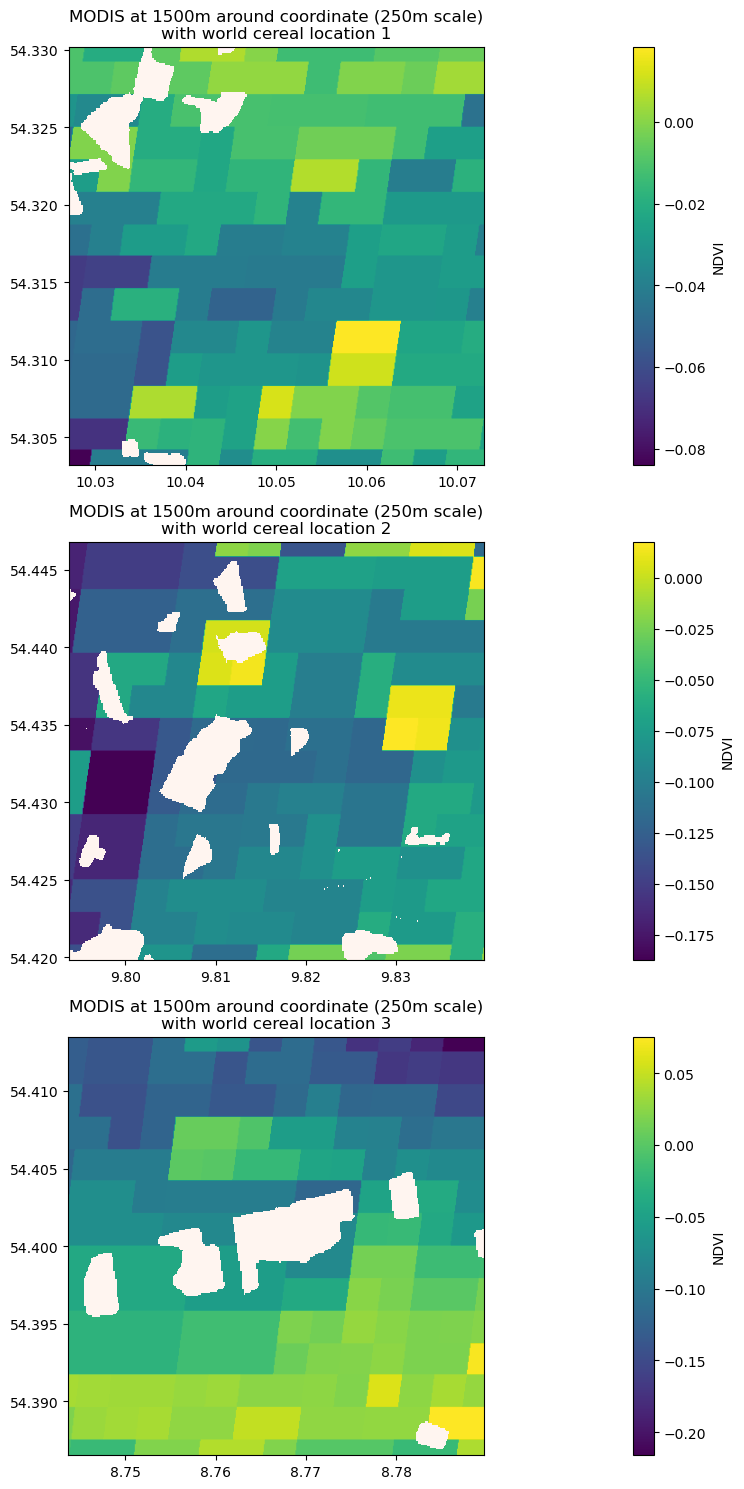

In [7]:
compare_WC_MODIS()

In [17]:
def compare_WC_thuenen(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                            buffer_size = 1500, mask_scale = 10, original_scale = 10, count_proportion = 0.9, count_threshold = 0,
                            savename = False, thuenen_year = 2021):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    
    def count_reducer(img):
        return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                    maxPixels=160, bestEffort=True)
    fig, axs = plt.subplots(3, 1, figsize = (30, 15))
    first_coord = True
    for coord_index in range(3):
        print(coord_index)
        coord = coords[coord_index]
        location = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size)
        grid_cell = location.bounds()
        thuenen_mask = ee.Image(f'projects/ee-martinparker637/assets/CTM_GER_{thuenen_year}_rst_v202_COG')
        if crop_type == 'M':
            thuenen_mask = thuenen_mask.select('b1').eq(1300)
        elif crop_type == 'ww':
            eujrc_crop = eujrc.select('classification').eq(1101)
        scale = thuenen_mask.select('b1').projection().nominalScale().getInfo()
        thuenen_mask = thuenen_mask.setDefaultProjection(thuenen_mask.projection(), scale = scale)# scale = original_scale)#, scale=original_scale*scale)
        thuenen_mask = thuenen_mask.updateMask(thuenen_mask)
        #if mask_scale > scale + 50:
        #    thuenen_mask = count_reducer(thuenen_mask).gt(count_threshold)
        region = thuenen_mask.clip(grid_cell).geometry()
        thuenen_vectors = thuenen_mask.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        thuenen_vectors = thuenen_vectors.map(lambda feat: feat.set('mask_used', 0))
        
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type])).map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
        scale = world_cereals.first().select('classification').projection().nominalScale().getInfo()
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale = scale)#, scale=original_scale*scale)
        if mask_scale > scale + 50:
            crop = count_reducer(crop).gt(count_threshold)
        crop = crop.updateMask(crop)
        region = crop.clip(grid_cell).geometry()
        WC_vectors = crop.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors = WC_vectors.map(lambda feat: feat.set('mask_used', 1))

        #Take out update mask if you want just worldcereals
        #WC_and_eujrc = world_cereals.filter(product_codes[crop_type]).mosaic().updateMask(eujrc_crop).select('classification').gte(0)
        WC_and_thuenen = thuenen_mask.updateMask(crop)
        WC_and_thuenen = WC_and_thuenen.updateMask(WC_and_thuenen)
        WC_thuenen_vectors = WC_and_thuenen.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_thuenen_vectors = WC_thuenen_vectors.map(lambda feat: feat.set('mask_used', 2))

        all_together = WC_vectors.merge(thuenen_vectors).merge(WC_thuenen_vectors)
        all_together.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        
        fig.colorbar(axs[coord_index].collections[0], label="mask code")
        axs[coord_index].set_title(f'Comparison of masks\n(yellow both, turquoise WC, purple Thuenen)\nlocation {coord_index + 1}')
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

In [3]:
def compare_crop_masks(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:2],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                      mask_scale=10, buffer_size=1500, savename = False):
    fig, axs = plt.subplots(1, 3, figsize = (20, 10))
    for mask_index in range(3):
        first_coord = True
        for coord in coords:
            print(coord)
            if mask_index == 0:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            elif mask_index == 1:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory, just_eujrc = True,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            elif mask_index == 2:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory, combine_eujrc = True,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            vectors = vectors.map(lambda feat: feat.buffer(-50))
            masked = csPlus_mask_collection(IC)
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
            ts = getTimeSeriesByRegion(masked,
                reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
                geometry = random_points,
                bands = ['EVI','NDVI'],#['B4','B8'],
                scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts)
            except:
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            name_choices = ['s2 cloud mask', 'google cloud mask']
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            colour = ['blue', 'red', 'green'][mask_index]
            if first_coord:
                mask_name = ['World cereal',
                             'EUJRC',
                             'World cereal and EUJRC'][mask_index]
                axs[mask_index].plot(xreduced['date'], xreduced['NDVI'], 
                                     alpha = 0.5, c = colour,
                                     label = f'Using {mask_name} crop masks, {reducer_code} reduced')
                first_coord = False
            else:
                axs[mask_index].plot(xreduced['date'], xreduced['NDVI'], 
                         alpha = 0.5, c=colour)
            axs[mask_index].set_title(mask_name)
            axs[mask_index].tick_params(labelrotation=45)
    fig.legend()
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

In [4]:
#compare_crop_masks(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:10], mask_scale = 10, buffer_size=1500, crop_type = 'M',
#                  N = 1500, year =2020)

In [86]:
def count_reducer(img):
    return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                maxPixels=1200, bestEffort=True)
def percentile_reducer(img):
    return img.reduceResolution(ee.Reducer.percentile([1]),#ee.Reducer.allNonZero(), #ee.Reducer.median(),#ee.Reducer.count(),
                                maxPixels=1200, bestEffort=False)

In [89]:
def try_different_resolution_reducers(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                            buffer_size = 1500, mask_scale = 10, original_scale = 10, count_threshold = 15,
                                     savename = False):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    fig, axs = plt.subplots(1, 3, figsize = (20, 10))
    first_coord = True
    for coord_index in range(3):
        print(coord_index)
        coord = coords[coord_index]
        location = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size)
        grid_cell = location.bounds()
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type])).map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
        crop = crop.updateMask(crop)
        #print(world_cereals.first().projection())
        print(world_cereals.first().projection().getInfo()['crs'])
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale=original_scale)
        #crop2 = mask_other(percentile_reducer(crop).gt(0))#
        crop2 = mask_other(count_reducer(crop).gt(count_threshold))
        crop2 = crop2.updateMask(crop2)
        region = crop.clip(grid_cell).geometry()
        region2 = crop2.clip(grid_cell).geometry()
        WC_vectors = crop.reduceToVectors(**{
            'geometry': region,
            'scale': 10,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors = WC_vectors.map(lambda feat: feat.set('mask_used', 1))
        WC_vectors2 = crop2.reduceToVectors(**{
            'geometry': region2,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        #WC_vectors2 = WC_vectors2.map(lambda feat: feat.buffer(-100))
        WC_vectors2 = WC_vectors2.map(lambda feat: feat.set('mask_used', 2))

        #all_together = WC_vectors2.merge(WC_vectors)
        #all_together.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        crop.geetools.plot(ax=axs[coord_index], bands = ['classification'], 
                           region = region, cmap="viridis")
        crop2.geetools.plot(ax=axs[coord_index], bands = ['classification'], 
                            region = region2, cmap="Reds", scale= mask_scale/100000)
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

0
EPSG:4326


/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(
/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


1
EPSG:4326


/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(
/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


2
EPSG:4326


/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(
/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


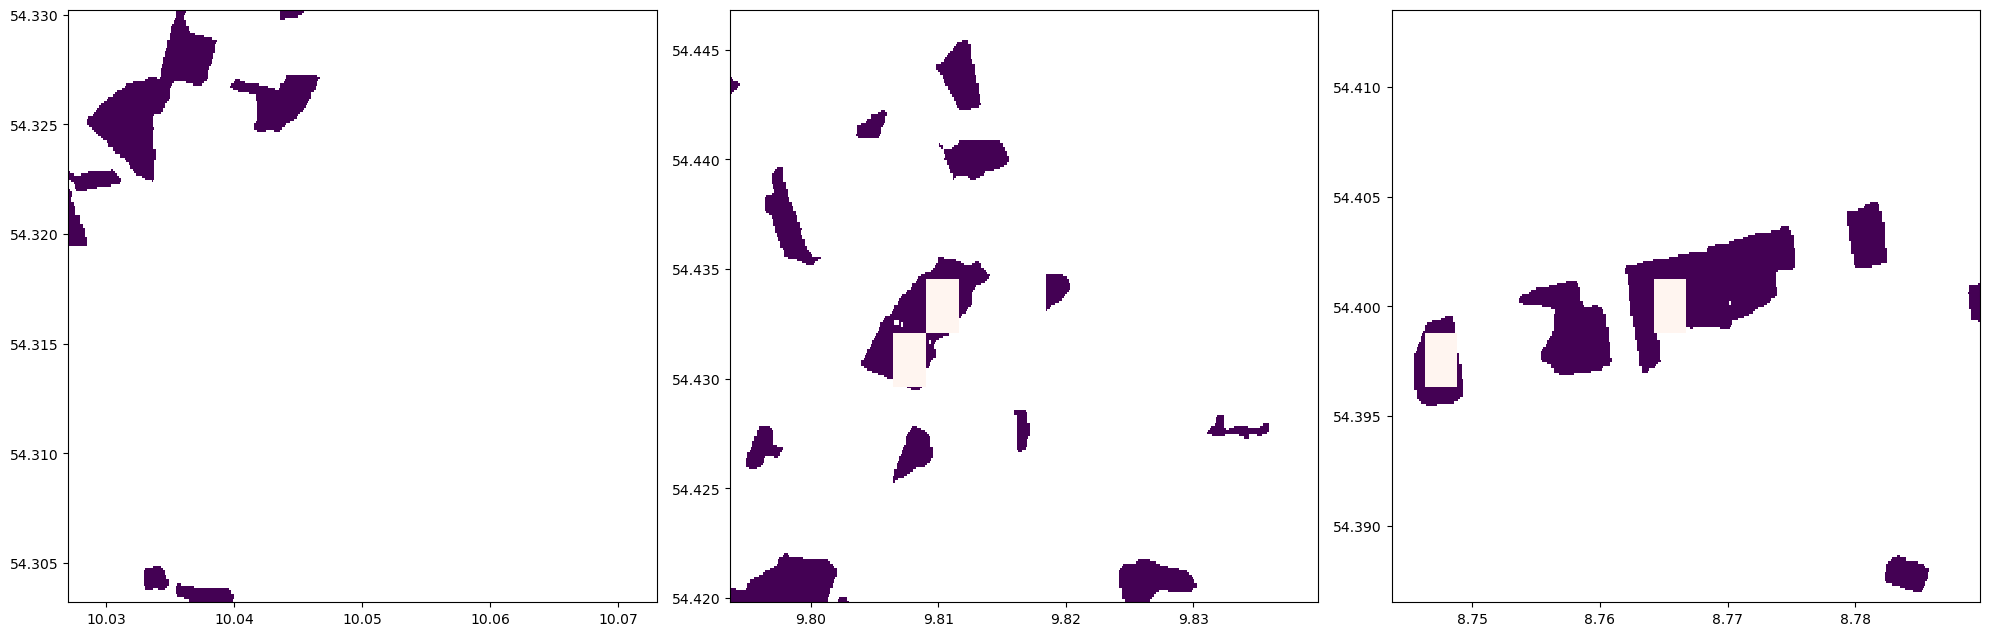

In [96]:
try_different_resolution_reducers(mask_scale = 250, original_scale =10, count_threshold = 800)

In [1]:
#compare_WC_thuenen(buffer_size = 6000, savename = 'Plots/WC_thuenen_2021')

In [2]:
#compare_WC_thuenen(buffer_size = 6000, thuenen_year = 2017, savename = 'Plots/WC_thuenen_2017')

In [13]:
def compare_crop_mask_images(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                            buffer_size = 1500, mask_scale = 10, original_scale = 10, count_proportion = 0.9, count_threshold = 0,
                            savename = False):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    #if count_threshold == 0:
    #    count_threshold = count_proportion*((mask_scale/original_scale)**2)
    print(count_threshold)
    def count_reducer(img):
        return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                    maxPixels=160, bestEffort=True)
    fig, axs = plt.subplots(3, 3, figsize = (20, 20))
    first_coord = True
    for coord_index in range(3):
        print(coord_index)
        coord = coords[coord_index]
        location = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size)
        grid_cell = location.bounds()
        
        eujrc_collection = ee.ImageCollection('JRC/D5/EUCROPMAP/V1').filterDate('2018-01-01', '2023-01-01')
        eujrc = eujrc_collection.mosaic()
        if crop_type == 'M':
            eujrc_crop = eujrc.select('classification').eq(216)
        elif crop_type == 'ww':
            eujrc_crop = eujrc.select('classification').eq(211)
        scale = eujrc_collection.first().select('classification').projection().nominalScale().getInfo()
        eujrc_crop = eujrc_crop.setDefaultProjection(eujrc_collection.first().projection(), scale = scale)# scale = original_scale)#, scale=original_scale*scale)
        eujrc_crop = eujrc_crop.updateMask(eujrc_crop)
        if mask_scale > scale + 50:
            eujrc_crop = count_reducer(eujrc_crop).gt(count_threshold)
        eujrc_crop = eujrc_crop.updateMask(eujrc_crop)
        region = eujrc_crop.clip(grid_cell).geometry()
        eujrc_vectors = eujrc_crop.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        eujrc_vectors = eujrc_vectors.map(lambda feat: feat.set('mask_used', 0))
        
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type])).map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
        scale = world_cereals.first().select('classification').projection().nominalScale().getInfo()
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale = scale)#, scale=original_scale*scale)
        if mask_scale > scale + 50:
            crop = count_reducer(crop).gt(count_threshold)
        crop = crop.updateMask(crop)
        region = crop.clip(grid_cell).geometry()
        WC_vectors = crop.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors = WC_vectors.map(lambda feat: feat.set('mask_used', 1))

        #Take out update mask if you want just worldcereals
        #WC_and_eujrc = world_cereals.filter(product_codes[crop_type]).mosaic().updateMask(eujrc_crop).select('classification').gte(0)
        WC_and_eujrc = eujrc_crop.updateMask(crop)
        WC_and_eujrc = WC_and_eujrc.updateMask(WC_and_eujrc)
        WC_eujrc_vectors = WC_and_eujrc.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_eujrc_vectors = WC_eujrc_vectors.map(lambda feat: feat.set('mask_used', 2))

        all_together = WC_vectors.merge(eujrc_vectors).merge(WC_eujrc_vectors)
        all_together.geetools.plot(ax=axs[0, coord_index], property = 'mask_used', cmap="viridis")
        #WC_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type]))#.map(mask_other)
        active_crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gte(0)
        specific_crop = world_cereals.mosaic().select('classification').gt(0)
        specific_crop = specific_crop.updateMask(specific_crop)
        active_crop = active_crop.setDefaultProjection(world_cereals.first().projection(), scale = 10)#, scale=original_scale*scale)
        specific_crop = specific_crop.setDefaultProjection(world_cereals.first().projection(), scale = 10)#, scale=original_scale*scale)
        #crop = count_reducer(crop).gt(count_threshold)
        #crop = crop.updateMask(crop)
        active_region = active_crop.clip(grid_cell).geometry()
        specific_region = specific_crop.clip(grid_cell).geometry()
        WC_vectors_active = active_crop.reduceToVectors(**{
            'geometry': active_region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors_active = WC_vectors_active.map(lambda feat: feat.set('mask_used', 1))
        WC_vectors_specific = specific_crop.reduceToVectors(**{
            'geometry': specific_region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors_specific = WC_vectors_specific.map(lambda feat: feat.set('mask_used', 2))
        alltogether_new = WC_vectors_active.merge(WC_vectors_specific)
        alltogether_new.geetools.plot(ax=axs[2, coord_index], property = 'mask_used', cmap="viridis")
        
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type])).map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification')#.gte(0)
        scale = world_cereals.first().select('classification').projection().nominalScale().getInfo()
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale = 10)#, scale=original_scale*scale)
        crop = count_reducer(crop)
        #crop = crop.gt(20)
        crop.geetools.plot(bands = ['classification'], ax = axs[1, coord_index], region=location, 
                                               crs = world_cereals.first().projection().getInfo()['crs'],
                                               cmap="viridis", scale = mask_scale/100000)
        
        #WC_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        #eujrc_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        #WC_eujrc_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        
        #crop.geetools.plot(bands = ['classification'], ax = axs[coord_index + 2], region=location, scale = mask_scale/10000)
        #eujrc_maize.geetools.plot(bands = ['classification'], ax = axs[coord_index + 1], region=location, scale = mask_scale/10000)
        #WC_and_eujrc.geetools.plot(bands = ['classification'], ax = axs[coord_index], region=location,cmap="Purples")
        fig.colorbar(axs[0, coord_index].collections[0], label="mask code")
        axs[0, coord_index].set_title(f'Comparison of masks\n(yellow both, turquoise WC, purple eujrc)\nlocation {coord_index + 1}')
        fig.colorbar(axs[1, coord_index].images[0], label="count of pixels that fit category")
        axs[1, coord_index].set_title(f'Counts of crop in pixel for WC\n(to check threshold)\nlocation {coord_index + 1}')
        fig.colorbar(axs[2, coord_index].collections[0], label="active cropland and crop specific")
        axs[2, coord_index].set_title(f'Comparison of WC active cropland and crop specific\n(yellow crop specific, purple active cropland)\nto check aggregation is not just active cropland') 
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

In [293]:
def worldcereal_to_check(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median', mask_scale = 250, buffer_size = 5000):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory, mask_scale = 1000)
    fig, ax = plt.subplots()
    world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100')
    crop = world_cereals.filter(product_codes[crop_type]).map(lambda image: image.updateMask(image.neq(0))).mosaic().select('classification').gt(0)
    crop = crop.updateMask(crop)
    N = 100
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})
    box_width = 0.02
    location = ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width)
    feats = ee.FeatureCollection([ee.Feature(random_points.geometry().buffer(10))])
    grid_cell_lon = coord[1]
    grid_cell_lat = coord[0]
    grid_cell = ee.Geometry.Point(grid_cell_lon, grid_cell_lat).buffer(buffer_size).bounds()
    region = crop.clip(grid_cell).geometry()
    vectors = crop.reduceToVectors(**{
        'geometry': location, #region,
        'scale': mask_scale,
        'maxPixels': 1e13,
        'bestEffort':True,
        'eightConnected': False,
        'geometryInNativeProjection': False,
        'geometryType':'bb'
        })#.map(lambda x: x.buffer(-20))
    crop.geetools.plot(bands = ['classification'], fc=vectors, ax = ax, region=location,cmap="viridis", #fc=points, 
                              color="red", scale = mask_scale/100000)
    